In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold


from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("telco-customer-churn.csv")

In [ ]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.shape

(7043, 21)

In [ ]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
data.dropna(inplace=True)
count = data.isnull().sum()
print(count)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [ ]:
data['Churn'].value_counts().sort_values(ascending=False)

No     5163
Yes    1869
Name: Churn, dtype: int64

In [ ]:
# Figuring out how many of the categoricals are actually numerical or vice-versa.
def grab_col_names (data, categorical = 10, cardinal =20):

    # categoricals
    cat_cols = [col for col in data.columns if data[col].dtype == 'O']
    #  [col for col in df.columns if str(df[col].dtypes) in ["category","object","bool"]]
    cat_but_car = [col for col in data.columns if data[col].dtype == 'O' and
                   data[col].nunique() > cardinal]
    num_but_cat = [col for col in data.columns if data[col].dtype != 'O' and
                   data[col].nunique() < categorical]
    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # numericals

    num_cols = [col for col in data.columns if data[col].dtype != 'O' and
                col not in num_but_cat]

    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names (data, categorical = 10, cardinal =20)

print('Categorical Columns :',cat_cols)
print('Numerical Columns :',num_cols)
print('Numerical seemed categorical columns :',cat_but_car)


Observations: 7032
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1
Categorical Columns : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen']
Numerical Columns : ['tenure', 'MonthlyCharges', 'TotalCharges']
Numerical seemed categorical columns : ['customerID']


count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.800000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


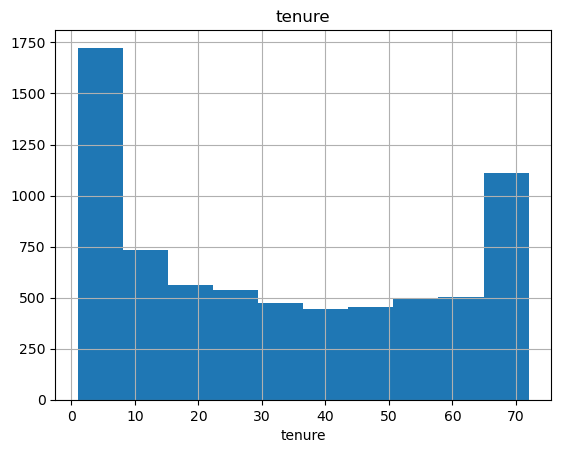

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.900000
40%        58.920000
50%        70.350000
60%        79.150000
70%        85.535000
80%        94.300000
90%       102.645000
95%       107.422500
99%       114.734500
max       118.750000
Name: MonthlyCharges, dtype: float64


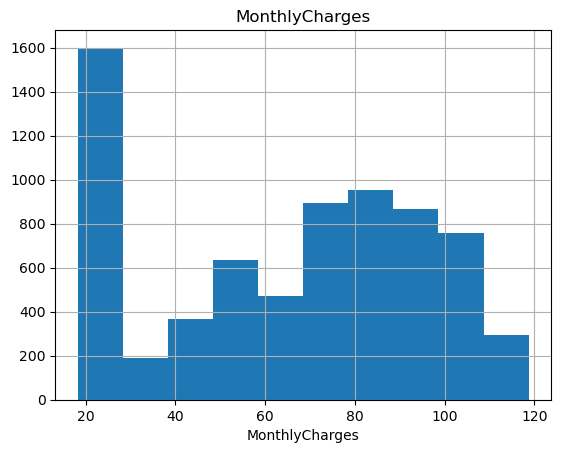

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


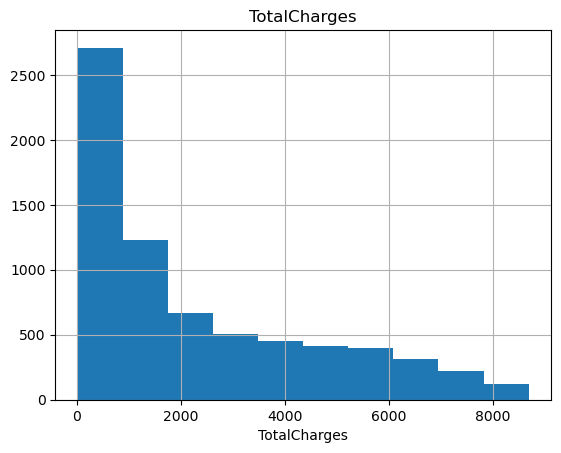

In [ ]:
# Analyzing Numerical Features ( Quantiles and Graph)
def num_summary(data, numeric_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(data[numeric_col].describe(quantiles).T)

    if plot:
        data[numeric_col].hist()
        plt.xlabel(numeric_col)
        plt.title(numeric_col)
        plt.show(block=True)
for col in num_cols:
    num_summary(data, col, True)

# Results:
# 1. Mean of the TENURE feature is close to it's median. Max value is almost 1.5*StandardDeviation away from the mean.
# 2. Mean of the MONTHLYCHARGES is close to it's median. Max value is almost 1.9*StandardDeviation away from the mean.

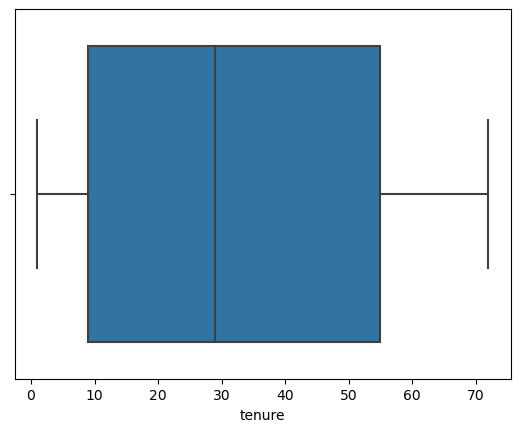

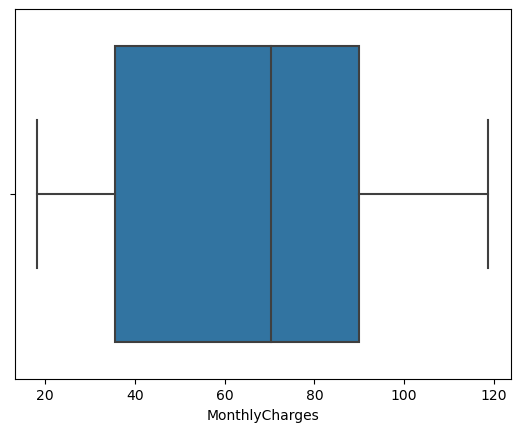

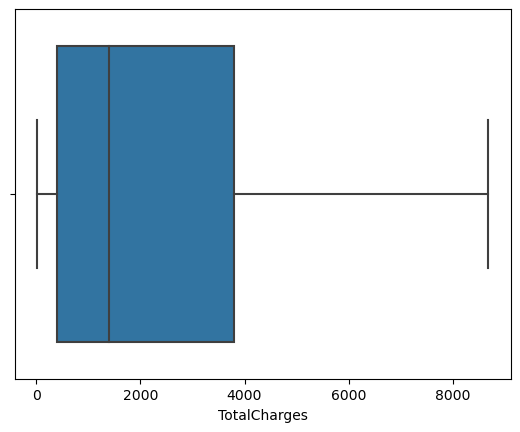

In [ ]:
#Checking for Outliers
def num_boxplot(data, numeric_col):
    sns.boxplot(x=data[numeric_col])
    plt.show()
for col in num_cols:
    num_boxplot(data, col)

In [ ]:
cat_cols = ["customerID", "gender", "Partner", "Dependents",\
                       "PhoneService", "MultipleLines","InternetService","OnlineSecurity",\
                      "OnlineBackup","DeviceProtection","TechSupport","StreamingTV",\
                      "StreamingMovies","Contract","PaperlessBilling","PaymentMethod","Churn"]
for each in cat_cols:
    unique_list = list(data[each].unique())
    for each_value in unique_list:
        data[each].replace(each_value,unique_list.index(each_value),inplace=True)

In [ ]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,29.85,29.85,0
1,1,1,0,1,0,34,1,1,0,1,...,1,0,0,0,1,1,1,56.95,1889.50,0
2,2,1,0,1,0,2,1,1,0,1,...,0,0,0,0,0,0,1,53.85,108.15,1
3,3,1,0,1,0,45,0,0,0,1,...,1,1,0,0,1,1,2,42.30,1840.75,0
4,4,0,0,1,0,2,1,1,1,0,...,0,0,0,0,0,0,0,70.70,151.65,1


In [ ]:
#EDA
data.corr()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,1.000000,-0.008463,0.008061,-0.000157,-0.004762,0.006798,-0.028269,-0.024319,-0.007693,-0.001245,...,-0.004288,0.003994,-0.001100,-0.010709,0.003950,-0.002138,-0.013432,-0.012937,0.001819,0.010129
gender,-0.008463,1.000000,-0.001819,0.001379,0.010349,0.005285,-0.007515,-0.010284,-0.002236,-0.004365,...,0.004526,0.000057,0.000578,-0.001339,0.000095,0.011902,-0.004928,-0.013779,0.000048,-0.008545
SeniorCitizen,0.008061,-0.001819,1.000000,-0.016957,-0.210550,0.015683,0.008392,0.113769,-0.032160,-0.210546,...,-0.156700,-0.223438,-0.129721,-0.120658,-0.141820,-0.156258,-0.093712,0.219874,0.102411,0.150541
Partner,-0.000157,0.001379,-0.016957,1.000000,-0.452269,-0.381912,-0.018397,-0.118037,-0.000513,-0.081078,...,-0.093391,-0.068277,-0.079066,-0.075310,-0.294094,-0.013957,-0.133280,-0.097825,-0.319072,0.149982
Dependents,-0.004762,0.010349,-0.210550,-0.452269,1.000000,0.163386,-0.001078,-0.019178,0.044030,0.188889,...,0.154819,0.179176,0.138809,0.125086,0.240556,0.110131,0.124002,-0.112343,0.064653,-0.163128
tenure,0.006798,0.005285,0.015683,-0.381912,0.163386,1.000000,0.007877,0.259112,-0.029835,0.147575,...,0.180895,0.146727,0.138208,0.142143,0.676734,-0.004823,0.340939,0.246862,0.825880,-0.354049
PhoneService,-0.028269,-0.007515,0.008392,-0.018397,-0.001078,0.007877,1.000000,0.674824,0.387266,0.125544,...,0.138938,0.123533,0.171773,0.164379,0.003019,-0.016696,-0.003106,0.248033,0.113008,0.011691
MultipleLines,-0.024319,-0.010284,0.113769,-0.118037,-0.019178,0.259112,0.674824,1.000000,0.186852,-0.066695,...,-0.012819,-0.066814,0.030524,0.027944,0.084037,-0.133538,0.026248,0.491412,0.412495,0.036148
InternetService,-0.007693,-0.002236,-0.032160,-0.000513,0.044030,-0.029835,0.387266,0.186852,1.000000,0.607412,...,0.662685,0.609422,0.712715,0.708336,0.099579,0.138166,0.008851,-0.322173,-0.175691,-0.047097
OnlineSecurity,-0.001245,-0.004365,-0.210546,-0.081078,0.188889,0.147575,0.125544,-0.066695,0.607412,1.000000,...,0.748684,0.790951,0.701526,0.704672,0.389138,0.333656,0.214330,-0.620532,-0.153234,-0.332443


<AxesSubplot:>

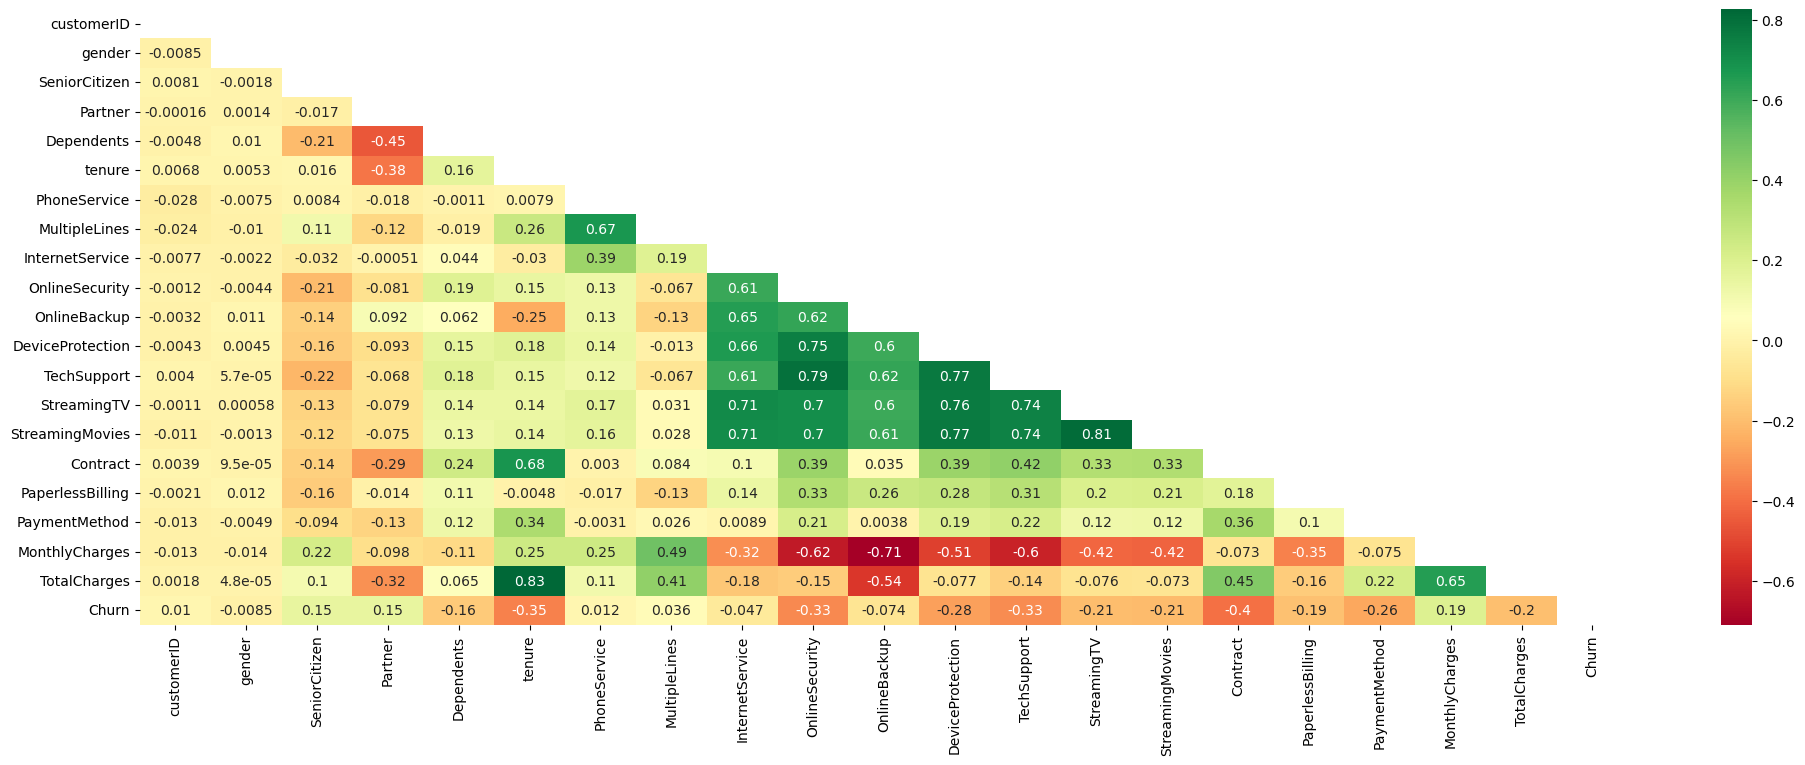

In [ ]:
plt.figure(figsize=(24,8))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdYlGn')

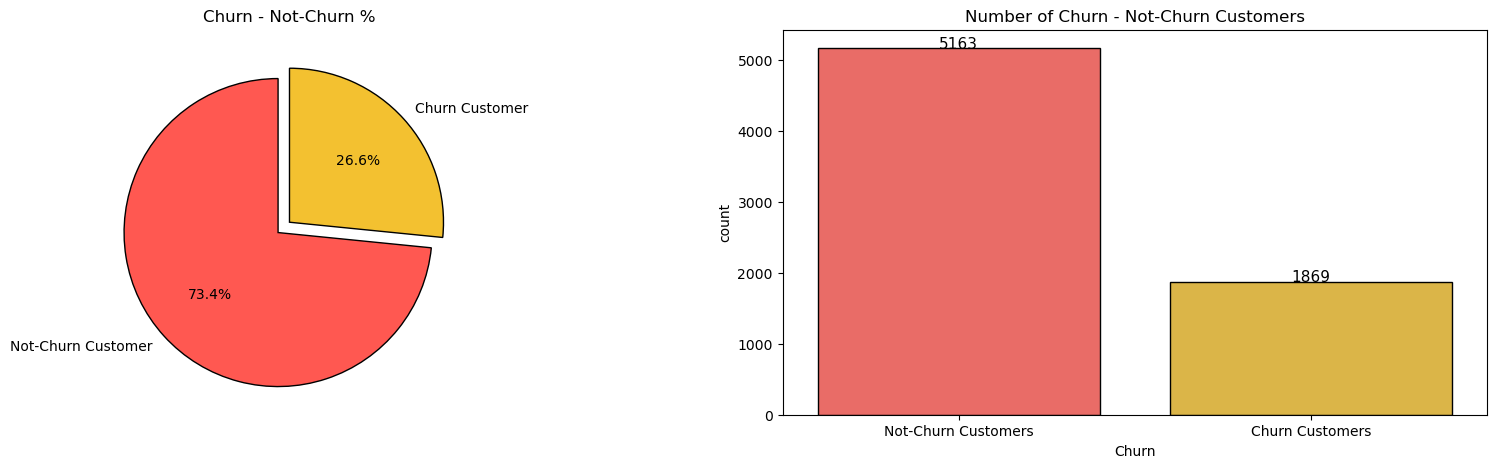

In [ ]:
colors = ['#FF5851', '#F3C130', '#414A6B', '#B49A85', '#1C1B20']
l = list(data['Churn'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
plt.pie(circle,labels = ['Not-Churn Customer','Churn Customer'],autopct = '%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Churn - Not-Churn %');

plt.subplot(1,2,2)
ax = sns.countplot('Churn',data = data,palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['Not-Churn Customers','Churn Customers'])

plt.title('Number of Churn - Not-Churn Customers');
plt.show()

In [ ]:
l1 = ['gender','SeniorCitizen','Partner','Dependents'] # Customer Information
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] # Services Signed Up for!
l3 = ['Contract','PaperlessBilling','PaymentMethod'] # Payment Information

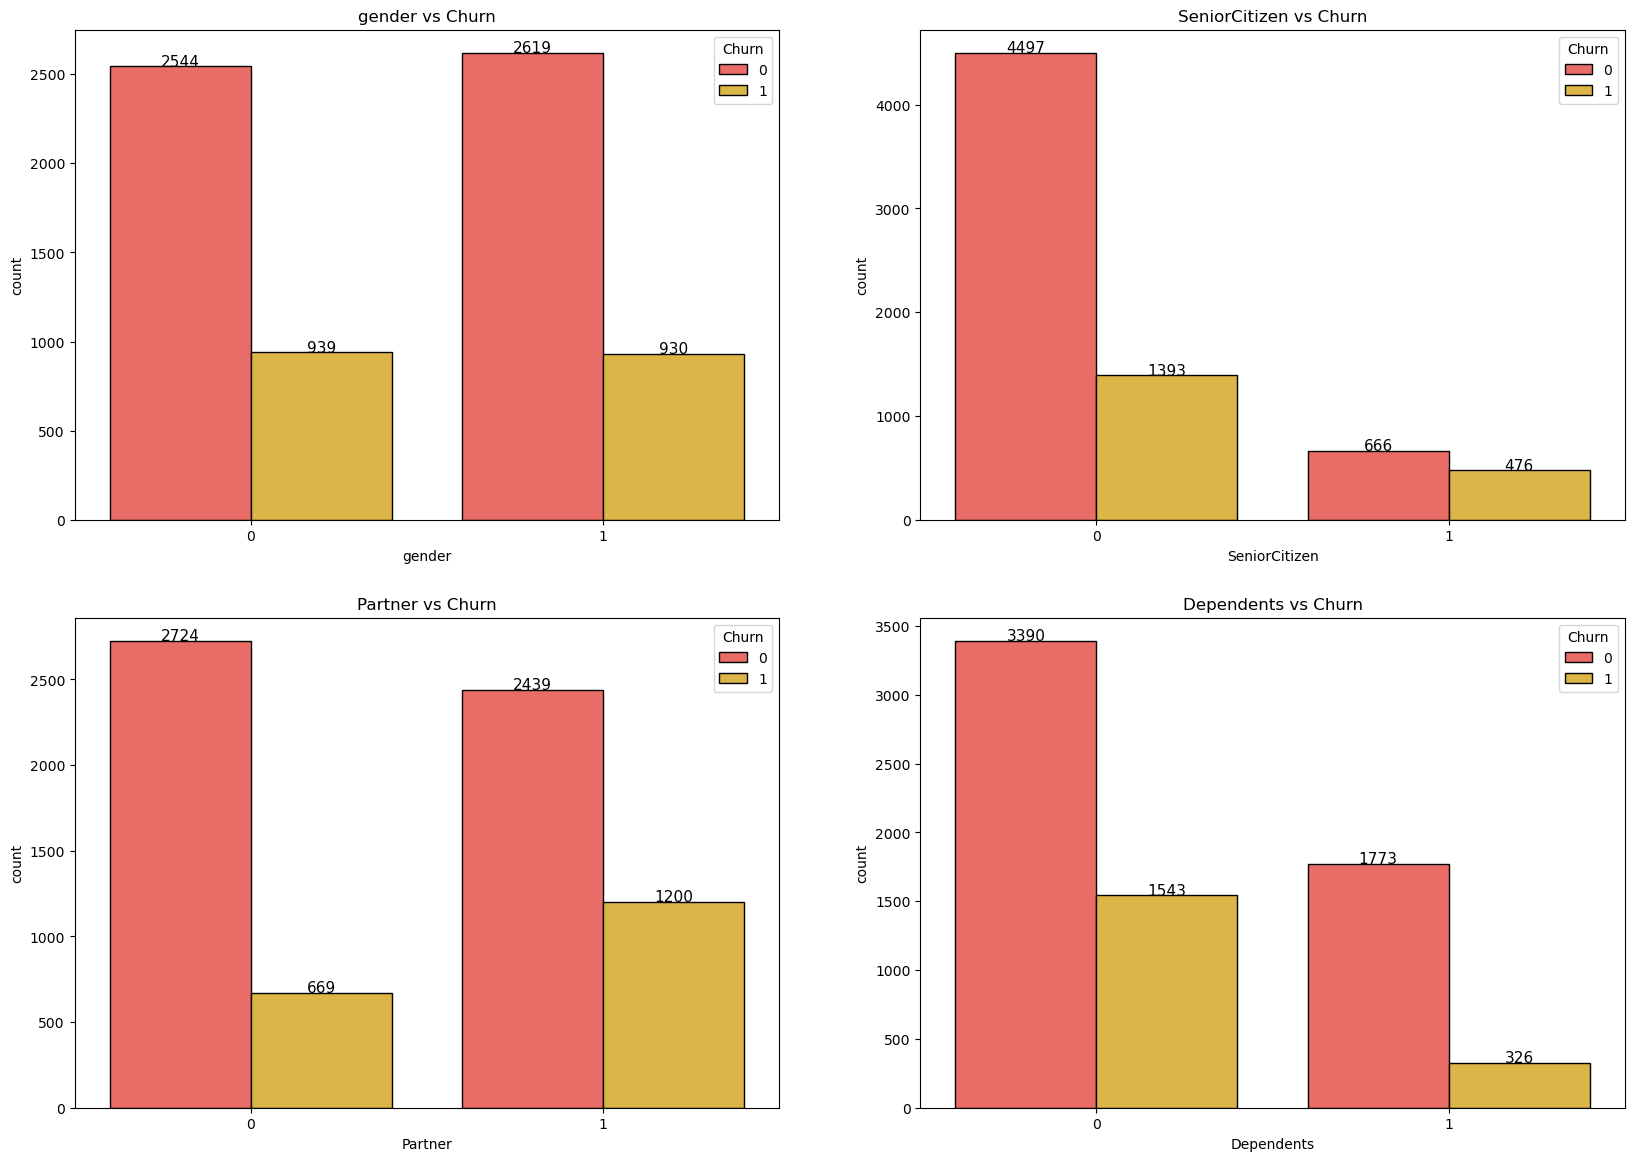

In [ ]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l1)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(l1[i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l1[i] + ' vs Churn'
    plt.title(title);

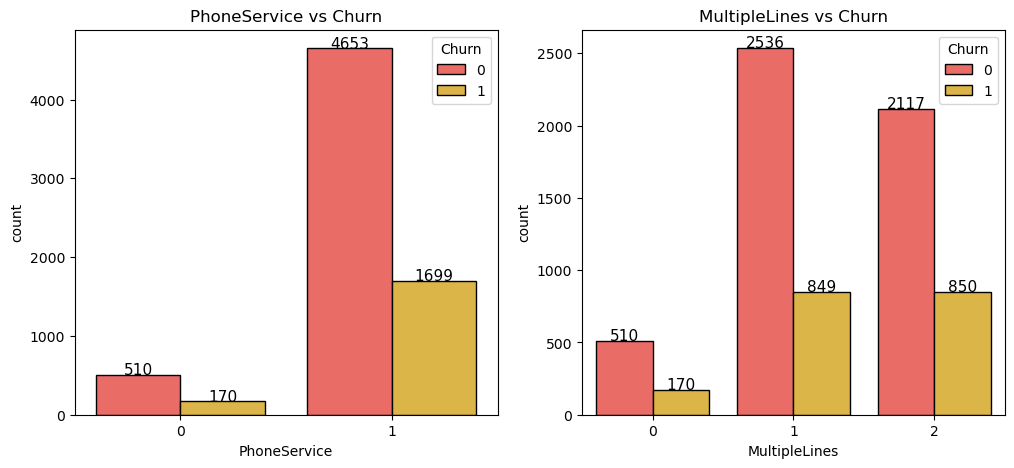

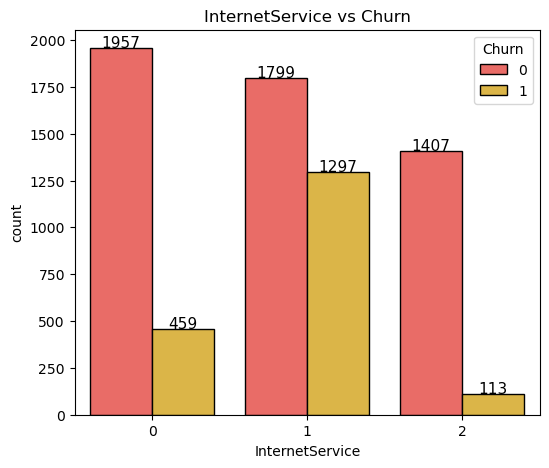

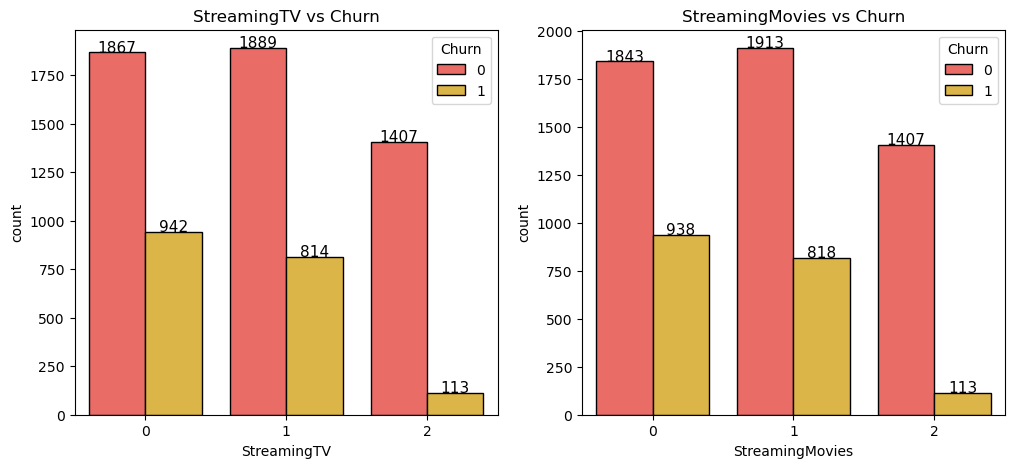

In [ ]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(l2[i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[i] + ' vs Churn'
    plt.title(title);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.countplot(l2[2],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l2[2] + ' vs Churn'
plt.title(title);

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(l2[i + 3],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[i + 3] + ' vs Churn'
    plt.title(title);

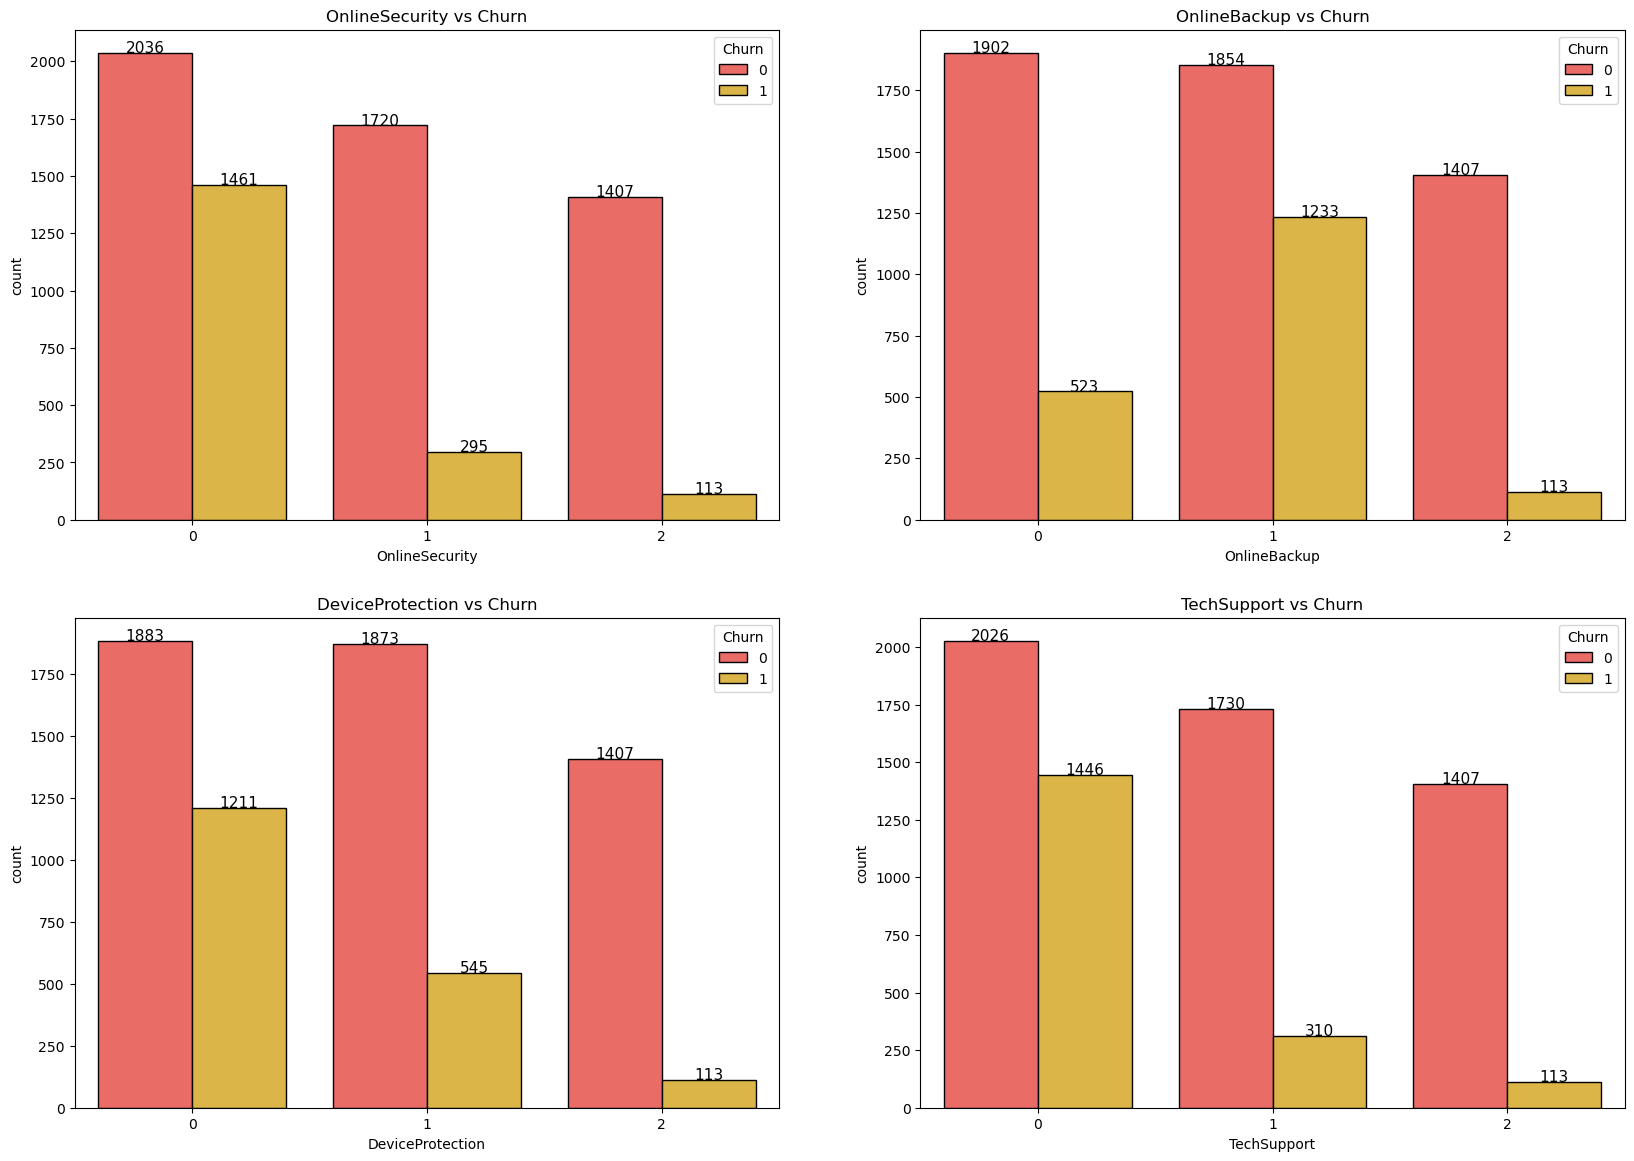

In [ ]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.countplot(l2[-4 + i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[-4 + i] + ' vs Churn'
    plt.title(title);

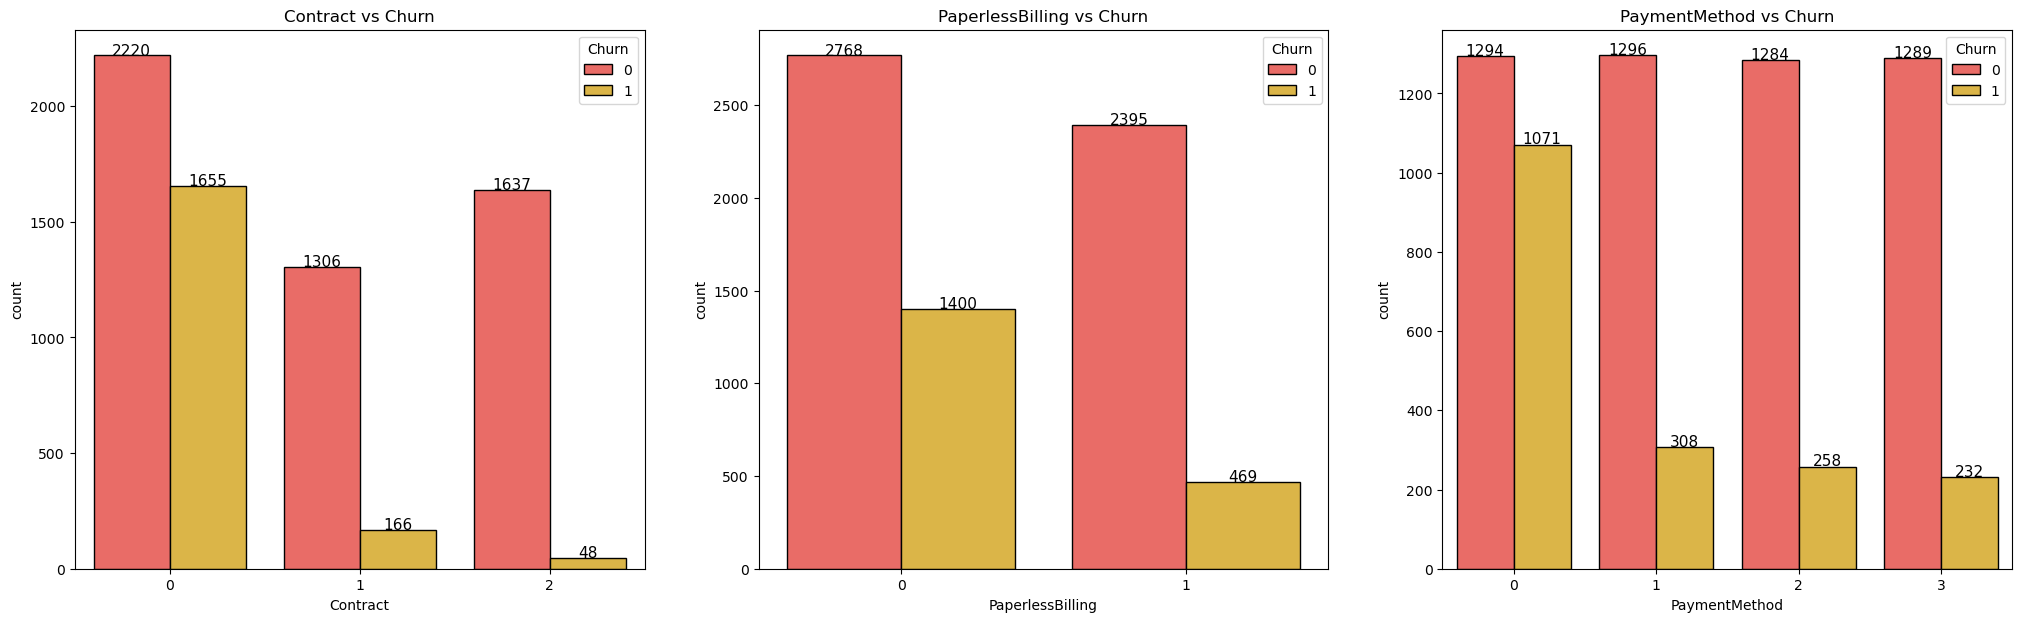

In [ ]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

plt.subplot(1,3,1)
ax = sns.countplot(l3[0],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[0] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,2)
ax = sns.countplot(l3[1],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[1] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,3)
ax = sns.countplot(l3[2],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[2] + ' vs Churn'
plt.title(title);

In [ ]:
X,y = data.drop("Churn",axis=1),data["Churn"]

In [ ]:
X

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29.85,29.85
1,1,1,0,1,0,34,1,1,0,1,1,1,0,0,0,1,1,1,56.95,1889.50
2,2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,53.85,108.15
3,3,1,0,1,0,45,0,0,0,1,1,1,1,0,0,1,1,2,42.30,1840.75
4,4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7027,1,0,0,1,24,1,2,0,1,1,1,1,1,1,1,0,1,84.80,1990.50
7039,7028,0,0,0,1,72,1,2,1,0,0,1,0,1,1,1,0,3,103.20,7362.90
7040,7029,0,0,0,1,11,0,0,0,1,1,0,0,0,0,0,0,0,29.60,346.45
7041,7030,1,1,0,0,4,1,2,1,0,1,0,0,0,0,0,0,1,74.40,306.60


In [ ]:
#Feature Selection

In [ ]:
# cor_target = abs(data.corr()["Churn"])
# features = cor_target[cor_target>0.1]
# df = data[features.index]
# df.shape

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X, y)
mutual_info

array([0.        , 0.        , 0.00367715, 0.0175063 , 0.01481371,
       0.08144144, 0.        , 0.01480793, 0.06432785, 0.0721864 ,
       0.04883633, 0.0343436 , 0.06711744, 0.02408219, 0.04070205,
       0.0973999 , 0.02606777, 0.04129495, 0.04450198, 0.04424437])

In [ ]:
X

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29.85,29.85
1,1,1,0,1,0,34,1,1,0,1,1,1,0,0,0,1,1,1,56.95,1889.50
2,2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,53.85,108.15
3,3,1,0,1,0,45,0,0,0,1,1,1,1,0,0,1,1,2,42.30,1840.75
4,4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7027,1,0,0,1,24,1,2,0,1,1,1,1,1,1,1,0,1,84.80,1990.50
7039,7028,0,0,0,1,72,1,2,1,0,0,1,0,1,1,1,0,3,103.20,7362.90
7040,7029,0,0,0,1,11,0,0,0,1,1,0,0,0,0,0,0,0,29.60,346.45
7041,7030,1,1,0,0,4,1,2,1,0,1,0,0,0,0,0,0,1,74.40,306.60


In [ ]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

Contract            0.097400
tenure              0.081441
OnlineSecurity      0.072186
TechSupport         0.067117
InternetService     0.064328
OnlineBackup        0.048836
MonthlyCharges      0.044502
TotalCharges        0.044244
PaymentMethod       0.041295
StreamingMovies     0.040702
DeviceProtection    0.034344
PaperlessBilling    0.026068
StreamingTV         0.024082
Partner             0.017506
Dependents          0.014814
MultipleLines       0.014808
SeniorCitizen       0.003677
PhoneService        0.000000
gender              0.000000
customerID          0.000000
dtype: float64

<AxesSubplot:>

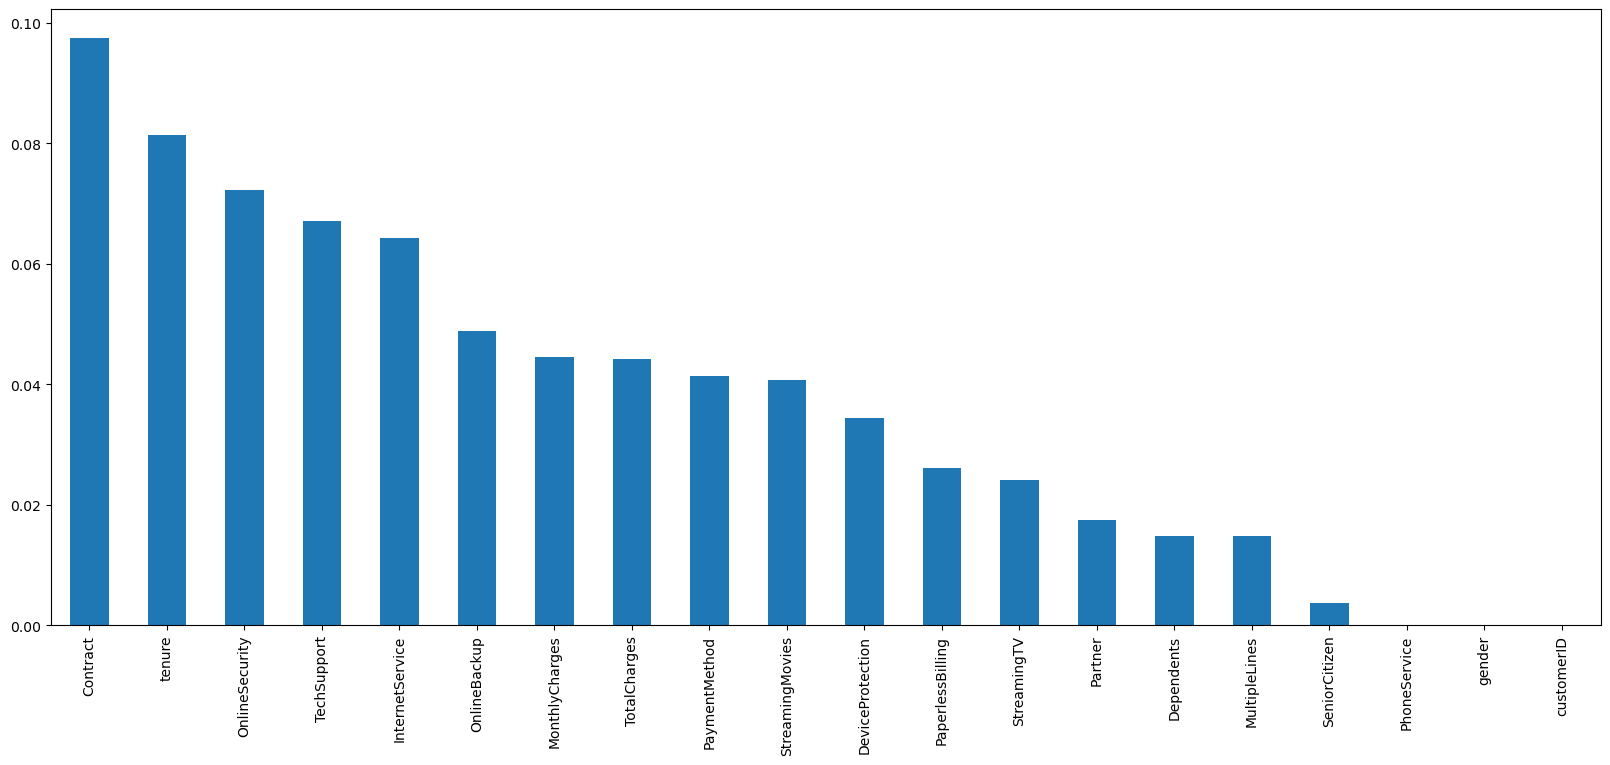

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [ ]:
# Select best 15 columns

from sklearn.feature_selection import SelectKBest
selected_cols = SelectKBest(mutual_info_classif, k=15)
selected_cols.fit(X, y)
X = X[X.columns[selected_cols.get_support()]]

In [ ]:
X

,SeniorCitizen,Partner,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,0,0,0,0,0,0,0,0,0,29.85,29.85
1,0,1,34,0,1,1,1,0,0,0,1,1,1,56.95,1889.50
2,0,1,2,0,1,0,0,0,0,0,0,0,1,53.85,108.15
3,0,1,45,0,1,1,1,1,0,0,1,1,2,42.30,1840.75
4,0,1,2,1,0,1,0,0,0,0,0,0,0,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,24,0,1,1,1,1,1,1,1,0,1,84.80,1990.50
7039,0,0,72,1,0,0,1,0,1,1,1,0,3,103.20,7362.90
7040,0,0,11,0,1,1,0,0,0,0,0,0,0,29.60,346.45
7041,1,0,4,1,0,1,0,0,0,0,0,0,1,74.40,306.60


In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
# SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
#!pip install -U imbalanced-learn
#!conda install -c conda-forge imbalanced-learn

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))


print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 1495
Before OverSampling, counts of label '0': 4130 

After OverSampling, the shape of train_X: (8260, 15)
After OverSampling, the shape of train_y: (8260,) 

After OverSampling, counts of label '1': 4130
After OverSampling, counts of label '0': 4130


In [ ]:
# import sweetviz as sv
# compare_report= sv.compare([X_train, 'Train'], [X_test, 'Test'])
# compare_report.show_html('compare.html', open_browser=False)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5625, 15) (5625,) (1407, 15) (1407,)


## Naive Bayes

In [ ]:
# Stage 1

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))



Accuracy :        0.6965174129353234
Precision :        0.46038863976083705
Recall :        0.8235294117647058
F1-Score :        0.5906040268456376


In [ ]:
# Stage 2

nb = GaussianNB()
nb.fit(X_train_res, y_train_res)

y_pred = nb.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))



Accuracy :        0.6801705756929638
Precision :        0.4461756373937677
Recall :        0.8422459893048129
F1-Score :        0.5833333333333334


## Logistic Regression

In [ ]:
# Stage 1

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))



Accuracy :        0.7882018479033405
Precision :        0.620253164556962
Recall :        0.5240641711229946
F1-Score :        0.5681159420289854


In [ ]:
# Stage 2

lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)

y_pred = lr.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))




Accuracy :        0.7334754797441365
Precision :        0.499151103565365
Recall :        0.786096256684492
F1-Score :        0.6105919003115264


## Random Forest

In [ ]:
# Stage 1

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))




Accuracy :        0.7860696517412935
Precision :        0.622895622895623
Recall :        0.4946524064171123
F1-Score :        0.5514157973174367


In [ ]:
# Stage 2

rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))





Accuracy :        0.7768301350390903
Precision :        0.5746268656716418
Recall :        0.6176470588235294
F1-Score :        0.595360824742268


### Hyperparameter Tuning

In [ ]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['log2', 'sqrt', 'None'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid, scoring="recall",
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

**Stage 1**

In [ ]:
# Stage 1

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['log2', 'sqrt',
                                                         'None'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, scoring='recall', verbose=2)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['log2', 'sqrt', 'None'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}  



In [ ]:

rf = RandomForestClassifier(n_estimators = 20, min_samples_split= 2, min_samples_leaf = 3, max_features = 'log2', max_depth = 10, bootstrap =  False)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))





Accuracy :        0.7917555081734187
Precision :        0.6382252559726962
Recall :        0.5
F1-Score :        0.56071964017991


**Stage 2**

In [ ]:
# Stage 2

rf_random.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['log2', 'sqrt',
                                                         'None'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, scoring='recall', verbose=2)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['log2', 'sqrt', 'None'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}  



In [ ]:
# Stage 2

rf = RandomForestClassifier(n_estimators = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 10, bootstrap =False)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))






Accuracy :        0.7704335465529495
Precision :        0.5550755939524838
Recall :        0.6871657754010695
F1-Score :        0.6140979689366786


## XGBoost

In [ ]:
# Stage 1

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))





Accuracy :        0.7746979388770433
Precision :        0.5953177257525084
Recall :        0.47593582887700536
F1-Score :        0.5289747399702823


In [ ]:
# Stage 2

xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

y_pred = xgb.predict(X_test)

print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))

Accuracy :        0.7626154939587776
Precision :        0.5497512437810945
Recall :        0.5909090909090909
F1-Score :        0.5695876288659794


### Hyperparameter Tuning

In [ ]:
# params = {
#  "n_estimators": [50,100, 200, 500,100],
#  "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
#  "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15,20],
#  "min_child_weight" : [ 1, 3, 5, 7, 9, 11, 13, 15 ],
#  "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.001, 0.0001 ],
#  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
# }

params = {
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb_model= RandomizedSearchCV(xgb,param_distributions=params,
                             n_iter = 5, scoring='recall',n_jobs= -1,cv=5,verbose = 3, random_state = 42)

**Stage 1**

In [ ]:
xgb_model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': range(3, 21, 3),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 10,
                                                      100],
                                        'reg_lambda': [1e-05, 0.01, 0.1, 1, 10,
                                                       100]},
                   random_state=42, scoring='recall', verbose=3)

In [ ]:
print ('Random grid: ', params, '\n')
# print the best parameters
print ('Best Parameters: ', xgb_model.best_params_, ' \n')

Random grid:  {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1], 'max_depth': range(3, 21, 3), 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [1e-05, 0.01, 0.1, 1, 10, 100]} 

Best Parameters:  {'reg_lambda': 1, 'reg_alpha': 10, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.5}  



In [ ]:
# Stage 1

xgb = XGBClassifier(reg_lambda= 1, reg_alpha= 10, max_depth= 3, learning_rate= 0.1, gamma= 0.4, colsample_bytree= 0.5)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))


Accuracy :        0.7967306325515281
Precision :        0.6506849315068494
Recall :        0.5080213903743316
F1-Score :        0.5705705705705707


**Stage 2**

In [ ]:
xgb_model.fit(X_train_res,y_train_res)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': range(3, 21, 3),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 10,
                                                      100],
                                        'reg_lambda': [1e-05, 0.01, 0.1, 1, 10,
                                                       100]},
                   random_state=42, scoring='recall', verbose=3)

In [ ]:
print ('Random grid: ', params, '\n')
# print the best parameters
print ('Best Parameters: ', xgb_model.best_params_, ' \n')

Random grid:  {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1], 'max_depth': range(3, 21, 3), 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [1e-05, 0.01, 0.1, 1, 10, 100]} 

Best Parameters:  {'reg_lambda': 0.1, 'reg_alpha': 1e-05, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}  



In [ ]:
xgb = XGBClassifier(reg_lambda= 0.1, reg_alpha= 1e-05, max_depth= 3, learning_rate= 0.1, gamma= 0.0, colsample_bytree= 0.6)
xgb.fit(X_train_res, y_train_res)

y_pred = xgb.predict(X_test)


print('Accuracy :       ', accuracy_score(y_test, y_pred))
print('Precision :       ', precision_score(y_test, y_pred))
print('Recall :       ', recall_score(y_test, y_pred))
print('F1-Score :       ', f1_score(y_test, y_pred))

Accuracy :        0.7661691542288557
Precision :        0.5458248472505092
Recall :        0.7165775401069518
F1-Score :        0.6196531791907515


### Result Discussion

* In terms of recall, we can see, **Naive Bayes** produces the better predictions with above 80% [Stage 1: 0.823 , Stage 2: 0.842] recall score where other algorithm's recall score results are:
    1. Logistic Regression - Stage 1: 0.523, Stage 2: 0.786
    2. XGBoost - Stage 1: 0.475, Stage 2: 0.590
    3. Random Forest - Stage 1: 0.494, Stage 2: 0.617

* After doing the parameter tuning, the recall score has improved for both the Random Forest and XGBoost classifier but could't get even close to Naive Bayes. So, still **Naive Bayes** is the best model. Recall score after parameter tuning:
    1. Random Forest - Stage 1: 0.500 , Stage 2: 0.687
    2. XGBoost - Stage 1: 0.508, Stage 2: 0.716
   
* Stage 2 where the oversampling SMOTE algorithm was used to handle the imbalanced issues, produces better results. Overall, **Naive Bayes** with Stage 2 is the best model.  